# Cross-validation and hyper-parameter tuning

In this notebook you will find example `sklearn` ML models estimated on the BBB data. 

In [1]:
from math import sqrt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

mpl.rcParams["figure.dpi"] = 150

Loading the data

In [2]:
bbb = pd.read_pickle("data/bbb.pkl")
bbb

,acctnum,gender,state,zip,zip3,first,last,book,nonbook,total,purch,child,youth,cook,do_it,reference,art,geog,buyer,training
0,10001,M,NY,10605,106,49,29,109,248,357,10,3,2,2,0,1,0,2,no,1
1,10002,M,NY,10960,109,39,27,35,103,138,3,0,1,0,1,0,0,1,no,1
2,10003,F,PA,19146,191,19,15,25,147,172,2,0,0,2,0,0,0,0,no,0
3,10004,F,NJ,07016,070,7,7,15,257,272,1,0,0,0,0,1,0,0,no,0
4,10005,F,NY,10804,108,15,15,15,134,149,1,0,0,1,0,0,0,0,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59996,F,NY,11967,119,9,9,15,12,27,1,1,0,0,0,0,0,0,no,1
49996,59997,F,NJ,08882,088,25,5,79,294,373,7,3,0,1,1,0,1,1,no,1
49997,59998,M,NJ,07410,074,3,3,15,178,193,1,0,0,0,0,1,0,0,no,1
49998,59999,M,NJ,07090,070,49,29,98,246,344,8,2,0,1,0,2,1,2,no,1


Converting categorical variables to 0/1 dummy variables

In [3]:
bbb["buyer_yes"] = rsm.ifelse(bbb.buyer == "yes", 1, 0)
bbb["gender_male"] = rsm.ifelse(bbb.gender == "M", 1, 0)

Adding a random number that should not become an important variable in any model. Setting a random seed to make the results reproducible. Try running the cell below multiple times to confirm

In [4]:
np.random.seed(1234)
bbb["rnd"] = np.random.randn(bbb.shape[0])
bbb["rnd"].head()

0    0.471435
1   -1.190976
2    1.432707
3   -0.312652
4   -0.720589
Name: rnd, dtype: float64

Creating a list of variable names

In [5]:
rvar = "buyer_yes"
evar = [
    "gender_male",
    "last",
    "total",
    "child",
    "youth",
    "cook",
    "do_it",
    "reference",
    "art",
    "geog",
    "rnd",
]
idvar = "acctnum"
lev = "Yes"

In [6]:
X = bbb[evar].copy()
y = bbb[rvar]

By passing information about the training variable to `rsm.scale_df` the variables will be scaled using *only* information from the training sample and you will retain the column headers

In [7]:
Xs = rsm.scale_df(X, train=bbb.training == 1, excl="gender_male")
Xs

,gender_male,last,total,child,youth,cook,do_it,reference,art,geog,rnd
0,1,1.021054,0.731271,0.960066,1.179122,0.447961,-0.302516,0.566258,-0.282477,0.861636,0.234210
1,1,0.898395,-0.347599,-0.382630,0.446865,-0.395135,0.352484,-0.260499,-0.282477,0.269004,-0.596482
2,0,0.162439,-0.180103,-0.382630,-0.285392,0.447961,-0.302516,-0.260499,-0.282477,-0.323628,0.714548
3,0,-0.328197,0.312531,-0.382630,-0.285392,-0.395135,-0.302516,0.566258,-0.282477,-0.323628,-0.157592
4,0,0.162439,-0.293409,-0.382630,-0.285392,0.026413,-0.302516,-0.260499,-0.282477,-0.323628,-0.361434
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,-0.205538,-0.894423,0.064935,-0.285392,-0.395135,-0.302516,-0.260499,-0.282477,-0.323628,-0.200591
49996,0,-0.450857,0.810092,0.960066,-0.285392,0.026413,0.352484,-0.260499,0.454017,0.269004,-0.204033
49997,1,-0.573516,-0.076650,-0.382630,-0.285392,-0.395135,-0.302516,0.566258,-0.282477,-0.323628,0.754321
49998,1,1.021054,0.667228,0.512501,-0.285392,0.026413,-0.302516,1.393015,0.454017,0.861636,-0.575946


Just as an exercise, we are going to create a new training variable using `ShuffleSplit`. This function from `sklearn` returns a python generator, so we use a loop to extract the relevant values. The training-test split will be 70-30. Note the use of `.copy()` to ensure changes to the training or test data are not reflected back in the bbb dataframe

In [8]:
ssplit = ShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)


array([24515, 21369,  7912, ..., 23924, 34086, 27439])

Notice that the proportion of 1s in `y` is not exactly the same when we use `ShuffleSplit`

Training: 0.0898, Test: 0.0919


`StratifiedShuffleSplit` is a better option to use when creating a training variable because it ensures the proportions of 1s in the training and test set are as close as possible. To demonstrate, we will first uses a 50-50 split. Now the proportions and number of 1s in the training and test set are identical

In [10]:

print(
    f"Training: {y[X.training == 1].mean():.4f}, Test: {y[X.training == 0].mean():.4f}",
    f"\nTraining: {y[X.training == 1].sum():,}, Test: {y[X.training == 0].sum():,}",
)

Training: 0.0904, Test: 0.0904 
Training: 2,261, Test: 2,261


Now re-create the training index so we have a 70-30 split

We will use the new training variable from here on out. We don't want the training variable to be used in estimation, so we will remove it from `X`

In [12]:
training = X.pop("training")

No we can standardize X and specify the `training` variable so only information from the training data is used in scaling

In [13]:
Xs = rsm.scale_df(X, train=training == 1, excl="gender_male")

Storing results for evaluation of different models

In [14]:
eval_dat = bbb[[idvar, rvar]].copy()
eval_dat["training"] = training

Lets start with a basic logistic regression model on standardized data

In [15]:
lr = smf.glm(
    formula="buyer_yes ~ gender_male + last + total + child + youth + cook + do_it + reference + art + geog + rnd",
    family=Binomial(link=logit()),
    data=Xs.assign(buyer_yes=y)[training == 1],
).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              buyer_yes   No. Observations:                35000
Model:                            GLM   Df Residuals:                    34988
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8410.5
Date:                Fri, 11 Mar 2022   Deviance:                       16821.
Time:                        18:16:35   Pearson chi2:                 3.48e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1188
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.1829      0.035    -92.193      0.000      -3.251      -3.115
gender_male     0.7564      0.043     17.678      0.000       0.673       0.840
last           -1.5878      0.055    -28.918      0.000      -1.695      -1.480
total           0.1982      0.048      4.133      0.000       0.104       0.292
child          -0.4360      0.047     -9.372      0.000      -0.527      -0.345
youth          -0.1555      0.043     -3.630      0.000      -0.239      -0.072
cook           -0.6248      0.049    -12.848      0.000      -0.720      -0.529
do_it          -0.8167      0.049    -16.601      0.000      -0.913      -0.720
reference       0.3062      0.038      7.987      0.000       0.231       0.381
art             1.6123      0.036     44.434      0.000       1.541       1.683
geog            0.9364      0.038     24.939      0.000       0.863       1.010
rnd            -0.0265      0.041     -0.644      0.520      -0.107       0.054
===============================================================================
"""

Logistic regression through sklearn with out any regularization gives the same results as `smf.glm` above

In [16]:
clf = LogisticRegression(random_state=1234, max_iter=1000, penalty="none").fit(
    Xs[training == 1], y[training == 1]
)

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
coef.round(4)

array([-3.1829,  0.7563, -1.5879,  0.1982, -0.436 , -0.1555, -0.6247,
       -0.8167,  0.3062,  1.6123,  0.9363, -0.0265])

Logistic regression through sklearn with *very strong* regularization. Note that if you are using regularization you should *always* standardize your explanatory variables first. The level of regularization is so strong that the coefficients for all explanatory variables have been set to zero

In [17]:
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=0.0000001
).fit(Xs[training == 1], y[training == 1])

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
coef.round(4)

array([-2.2545,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ])

Logistic regression through sklearn with *minimal* regularization same result as not using any penalty

In [18]:
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=100000
).fit(Xs[training == 1], y[training == 1])

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
coef.round(4)

array([-3.1829,  0.7564, -1.5878,  0.1982, -0.436 , -0.1555, -0.6247,
       -0.8167,  0.3062,  1.6123,  0.9364, -0.0265])

Logistic regression in sklearn with strong L1 regularization will set the coefficient for the `rnd` variable to zero

In [19]:
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=0.05
).fit(Xs[training == 1], y[training == 1])

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
coef = pd.DataFrame({"labels": evar, "coefficients": coef[1:], "OR": np.exp(coef[1:])})
coef

,labels,coefficients,OR
0,gender_male,0.704872,2.023588
1,last,-1.511225,0.220640
2,total,0.139106,1.149246
3,child,-0.381726,0.682682
4,youth,-0.115520,0.890902
5,cook,-0.563210,0.569378
6,do_it,-0.745222,0.474629
7,reference,0.270664,1.310835
8,art,1.561671,4.766781
9,geog,0.891454,2.438672


In [20]:
coef.query("coefficients == 0")

,labels,coefficients,OR
10,rnd,0.0,1.0


Storing predictions from LogisticRegression (sklearn)

In [21]:
eval_dat["y_lr"] = clf.predict_proba(Xs)[:, 1]

Tuning logistic regression with L1 penalty (LASSO)

In [22]:
clf = LogisticRegression(random_state=1234, max_iter=1000, solver="saga", penalty="l1")
param_grid = {"C": [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]}
scoring = {"AUC": "roc_auc"}
lr_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(Xs[training == 1], y[training == 1])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Display the results from CV for logistic regression with regularization

In [23]:
cv_results = pd.DataFrame(lr_cv.cv_results_).sort_values(by=["rank_test_AUC"])
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
0,0.084219,0.011946,0.002684,0.000136,1,{'C': 1},0.809517,0.818689,0.810102,0.816834,0.813282,0.813685,0.003614,1
1,0.081811,0.011200,0.002688,0.000124,0.5,{'C': 0.5},0.809516,0.818706,0.810029,0.816846,0.813299,0.813679,0.003636,2
2,0.084432,0.008838,0.002936,0.000560,0.25,{'C': 0.25},0.809504,0.818705,0.809942,0.816846,0.813344,0.813668,0.003655,3
3,0.075191,0.007968,0.002598,0.000078,0.1,{'C': 0.1},0.809500,0.818732,0.809662,0.816818,0.813517,0.813646,0.003715,4
4,0.070865,0.006474,0.002643,0.000068,0.05,{'C': 0.05},0.809291,0.818665,0.808997,0.816767,0.813741,0.813492,0.003883,5
5,0.070327,0.004593,0.002724,0.000173,0.025,{'C': 0.025},0.808437,0.818076,0.807428,0.816256,0.813616,0.812763,0.004203,6
6,0.070577,0.002206,0.002881,0.000683,0.01,{'C': 0.01},0.804170,0.815265,0.802119,0.812382,0.809766,0.808740,0.004932,7
7,0.068840,0.001835,0.002779,0.000450,0.005,{'C': 0.005},0.786522,0.800898,0.783626,0.796770,0.792318,0.792027,0.006359,8
8,0.063390,0.003494,0.002225,0.000206,0.0025,{'C': 0.0025},0.765408,0.777231,0.761318,0.774265,0.770765,0.769797,0.005785,9


We now have to use `iloc` because the df has been sorted and .loc[0, "param_C"] might return the wrong row!

In [24]:
cv_results.iloc[0, cv_results.columns.get_loc("param_C")]

1

Note that the random variable ("rnd") was *not* removed or set to 0!

In [25]:
coef = lr_cv.best_estimator_.coef_
pd.DataFrame({"labels": evar, "coefficients": coef[0], "OR": np.exp(coef[0])})

,labels,coefficients,OR
0,gender_male,0.753761,2.124976
1,last,-1.583870,0.205180
2,total,0.195192,1.215545
3,child,-0.433185,0.648441
4,youth,-0.153442,0.857750
5,cook,-0.621593,0.537088
6,do_it,-0.813038,0.443509
7,reference,0.304380,1.355784
8,art,1.609682,5.001221
9,geog,0.934044,2.544779


In [26]:
eval_dat["y_lasso"] = lr_cv.predict_proba(Xs)[:, 1]

Estimate a Neural Net for classification from SKLEARN

In [27]:
clf = MLPClassifier(
    activation="tanh",
    solver="lbfgs",
    alpha=0.01,
    hidden_layer_sizes=(1,),
    random_state=1234,
    max_iter=10000,
).fit(Xs[training == 1], y[training == 1])

In [28]:
eval_dat["y_nn"] = clf.predict_proba(Xs)[:, 1]
eval_dat

,acctnum,buyer_yes,training,y_lr,y_lasso,y_nn
0,10001,0,1,0.020020,0.017953,0.017703
1,10002,0,0,0.017419,0.015877,0.015819
2,10003,0,1,0.017345,0.015487,0.015429
3,10004,0,0,0.073923,0.077197,0.076124
4,10005,0,1,0.021545,0.020111,0.019782
...,...,...,...,...,...,...
49995,59996,0,1,0.036383,0.033690,0.032638
49996,59997,0,1,0.114187,0.112181,0.112373
49997,59998,0,1,0.181453,0.191942,0.195078
49998,59999,0,0,0.124892,0.132982,0.134921


Use CV to tune the NN. Below we tune on the size of the NN the level of regularization

In [29]:
nr_hnodes = range(1, 5)
hls = list(zip(nr_hnodes)) + list(zip(nr_hnodes, nr_hnodes))
hls

[(1,), (2,), (3,), (4,), (1, 1), (2, 2), (3, 3), (4, 4)]

In [30]:
param_grid = {"hidden_layer_sizes": hls, "alpha": [0.001, 0.01, 0.05]}
scoring = {"AUC": "roc_auc"}

In [31]:
clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(Xs[training == 1], y[training == 1])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [32]:
clf_cv.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (3, 3)}

In [33]:
clf_cv.best_score_

0.8179680426646977

In [34]:
cv_results = pd.DataFrame(clf_cv.cv_results_).sort_values(by="rank_test_AUC")
cv_results.iloc[
    0,
    [
        cv_results.columns.get_loc(c)
        for c in ["param_alpha", "param_hidden_layer_sizes"]
    ],
]

param_alpha                   0.01
param_hidden_layer_sizes    (3, 3)
Name: 14, dtype: object

In [35]:
eval_dat["y_nn_cv"] = clf_cv.predict_proba(Xs)[:, 1]
eval_dat

,acctnum,buyer_yes,training,y_lr,y_lasso,y_nn,y_nn_cv
0,10001,0,1,0.020020,0.017953,0.017703,0.013459
1,10002,0,0,0.017419,0.015877,0.015819,0.016466
2,10003,0,1,0.017345,0.015487,0.015429,0.012216
3,10004,0,0,0.073923,0.077197,0.076124,0.077285
4,10005,0,1,0.021545,0.020111,0.019782,0.018437
...,...,...,...,...,...,...,...
49995,59996,0,1,0.036383,0.033690,0.032638,0.032139
49996,59997,0,1,0.114187,0.112181,0.112373,0.116663
49997,59998,0,1,0.181453,0.191942,0.195078,0.208795
49998,59999,0,0,0.124892,0.132982,0.134921,0.131387


The `evalbin` command below requires `pyrsm >= 0.4.2`. Install from a terminal in jupyter using the command below, and then restart the notebook kernel:

`pip3 install --user 'pyrsm>=0.4.2'`

In [36]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(
    dct, "buyer_yes", 1, ["y_lr", "y_lasso", "y_nn", "y_nn_cv"], cost=0.5, margin=6
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_lr,2356,8624,23211,809,35000,0.744,0.729,0.215,0.333,0.730,0.224,8646.0,0.982,1.575,0.314,0.814
1,training,y_lasso,2342,8501,23334,823,35000,0.740,0.733,0.216,0.334,0.734,0.226,8630.5,0.980,1.592,0.310,0.814
2,training,y_nn,2327,8373,23462,838,35000,0.735,0.737,0.217,0.336,0.737,0.228,8612.0,0.978,1.610,0.306,0.814
3,training,y_nn_cv,2350,8245,23590,815,35000,0.742,0.741,0.222,0.342,0.741,0.235,8802.5,1.000,1.662,0.303,0.822
4,test,y_lr,984,3741,9902,373,15000,0.725,0.726,0.208,0.324,0.726,0.213,3541.5,0.967,1.499,0.315,0.806
5,test,y_lasso,980,3678,9965,377,15000,0.722,0.730,0.210,0.326,0.730,0.216,3551.0,0.969,1.525,0.311,0.806
6,test,y_nn,979,3631,10012,378,15000,0.721,0.734,0.212,0.328,0.733,0.219,3569.0,0.974,1.548,0.307,0.806
7,test,y_nn_cv,993,3595,10048,364,15000,0.732,0.736,0.216,0.334,0.736,0.226,3664.0,1.000,1.597,0.306,0.813


### Decision tree

Estimate a basic decision tree model

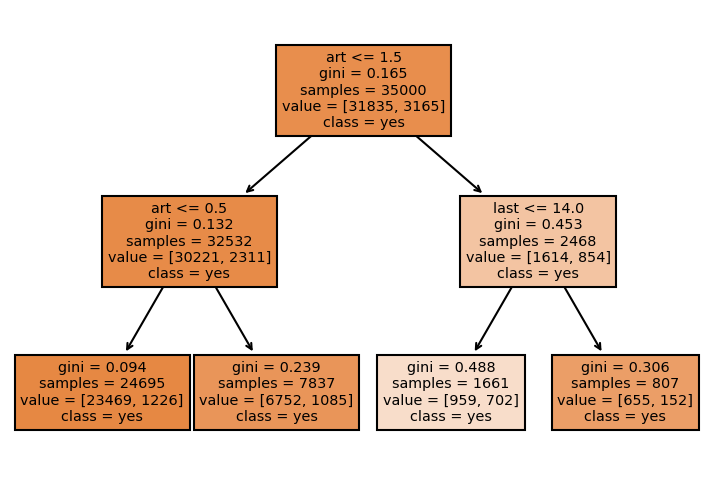

In [37]:
clf = tree.DecisionTreeClassifier(max_depth=2).fit(X[training == 1], y[training == 1])
fig = tree.plot_tree(clf, feature_names=evar, class_names=["yes", "no"], filled=True)

Estimate a larger tree that is likely to overfit the data

In [38]:
clf = tree.DecisionTreeClassifier(max_depth=20).fit(X[training == 1], y[training == 1])

Predict for the entire dataset

In [39]:
eval_dat["y_tree"] = clf.predict_proba(X)[:, 1]

In [40]:
param_grid = {"max_depth": list(range(2, 20))}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X[training == 1], y[training == 1])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [41]:
clf_cv.best_params_

{'max_depth': 7}

In [42]:
clf_cv.best_score_

0.7718967593319721

In [43]:
cv_results = pd.DataFrame(clf_cv.cv_results_).sort_values(by="rank_test_AUC")
cv_results.iloc[0, cv_results.columns.get_loc("param_max_depth")]

7

In [44]:
eval_dat["y_tree_cv"] = clf_cv.predict_proba(X)[:, 1]

### Random Forest

How many features to consider at each node split? Use `sqrt(nr_columns)` as an approximation

In [45]:
sqrt(X.shape[1])

3.3166247903554

In [46]:
clf = RandomForestClassifier(
    n_estimators=100, max_features=3, oob_score=True, random_state=1234
).fit(X[training == 1], y[training == 1])

If we do not use the OOB values in prediction, and check out the AUC value in the training sample!!!

In [47]:
eval_dat["y_rf"] = clf.predict_proba(X)[:, 1]

In [48]:
eval_dat["y_rf_oob"] = eval_dat.y_rf
eval_dat.loc[training == 1, "y_rf_oob"] = clf.oob_decision_function_[:, 1]

In [49]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(dct, "buyer_yes", 1, ["y_rf", "y_rf_oob"], cost=0.5, margin=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_rf,3165,3111,28724,0,35000,1.000,0.902,0.504,0.670,0.911,0.625,15852.0,1.00,5.052,0.179,1.000
1,training,y_rf_oob,2178,9696,22139,987,35000,0.688,0.695,0.183,0.290,0.695,0.171,7131.0,0.45,1.201,0.339,0.749
2,test,y_rf,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,1.00,1.256,0.335,0.760
3,test,y_rf_oob,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,1.00,1.256,0.335,0.760


Random Forest with cross validation and grid search

In [50]:
clf = RandomForestClassifier()
param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_features": range(3, 5),
}
scoring = {"AUC": "roc_auc"}

In [51]:
clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X[training == 1], y[training == 1])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [52]:
clf_cv.best_params_

{'max_features': 3, 'n_estimators': 500}

In [53]:
clf_cv.best_score_

0.7655188148011407

If we do *not* using OOB values, again, note the AUC value!!!

In [54]:
pred = clf_cv.predict_proba(X[training == 1])
fpr, tpr, thresholds = metrics.roc_curve(y[training == 1].values, pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

1.0

If we want to use the OOB scores for the training data instead, we have to re-estimate because it is no possible to pass the 'oob_score' option when using GridSearchCV

In [55]:
clf = RandomForestClassifier(
    n_estimators=clf_cv.best_params_["n_estimators"],
    max_features=clf_cv.best_params_["max_features"],
    oob_score=True,
    random_state=1234,
).fit(X[training == 1], y[training == 1])
pred = clf.oob_decision_function_

In [56]:
fpr, tpr, thresholds = metrics.roc_curve(y[training == 1], pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7631147819609951

In [57]:
# using the oob predictions for the training sample
eval_dat["y_rf_cv"] = 0  # set some initial value
eval_dat.loc[training == 1, "y_rf_cv"] = clf.oob_decision_function_[:, 1]
eval_dat.loc[training == 0, "y_rf_cv"] = clf.predict_proba(X[training == 0])[:, 1]

In [58]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(dct, "buyer_yes", 1, ["y_rf", "y_rf_oob", "y_rf_cv"], cost=0.5, margin=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_rf,3165,3111,28724,0,35000,1.000,0.902,0.504,0.670,0.911,0.625,15852.0,1.000,5.052,0.179,1.000
1,training,y_rf_oob,2178,9696,22139,987,35000,0.688,0.695,0.183,0.290,0.695,0.171,7131.0,0.450,1.201,0.339,0.749
2,training,y_rf_cv,2221,9599,22236,944,35000,0.702,0.698,0.188,0.296,0.699,0.179,7416.0,0.468,1.255,0.338,0.763
3,test,y_rf,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.999,1.256,0.335,0.760
4,test,y_rf_oob,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.999,1.256,0.335,0.760
5,test,y_rf_cv,951,4138,9505,406,15000,0.701,0.697,0.187,0.295,0.697,0.178,3161.5,1.000,1.242,0.339,0.766


### XGBoost

In [59]:
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    # early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234,
).fit(X[training == 1], y[training == 1], verbose=True)

/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [60]:
# predict for the entire dataset
eval_dat["y_xgb"] = clf.predict_proba(X)[:, 1]

In [61]:
# XGBoost with cross-validation and grid search
clf = xgb.XGBClassifier()
param_grid = {
    "max_depth": list(range(1, 3)),
    "n_estimators": list(range(100, 301, 100)),
}
scoring = {"AUC": "roc_auc"}

In [62]:
clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X[training == 1], y[training == 1])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:21:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117781407/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
print(clf_cv.best_params_)
print(clf_cv.best_score_)

{'max_depth': 1, 'n_estimators': 200}
0.8112101026446842


In [64]:
# predict for the entire dataset
eval_dat["y_xgb_cv"] = clf_cv.predict_proba(X)[:, 1]

In [65]:
# performance evaluations
models = list(eval_dat.columns.values[3:])
models

['y_lr',
 'y_lasso',
 'y_nn',
 'y_nn_cv',
 'y_tree',
 'y_tree_cv',
 'y_rf',
 'y_rf_oob',
 'y_rf_cv',
 'y_xgb',
 'y_xgb_cv']

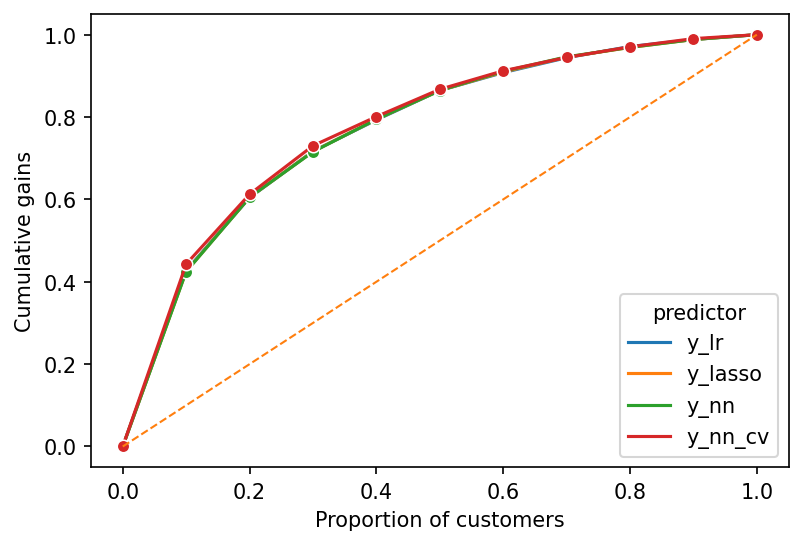

In [66]:
# no meaningful difference in performance visible
fig = rsm.gains_plot(eval_dat.query("training == 0"), "buyer_yes", 1, models[0:4])

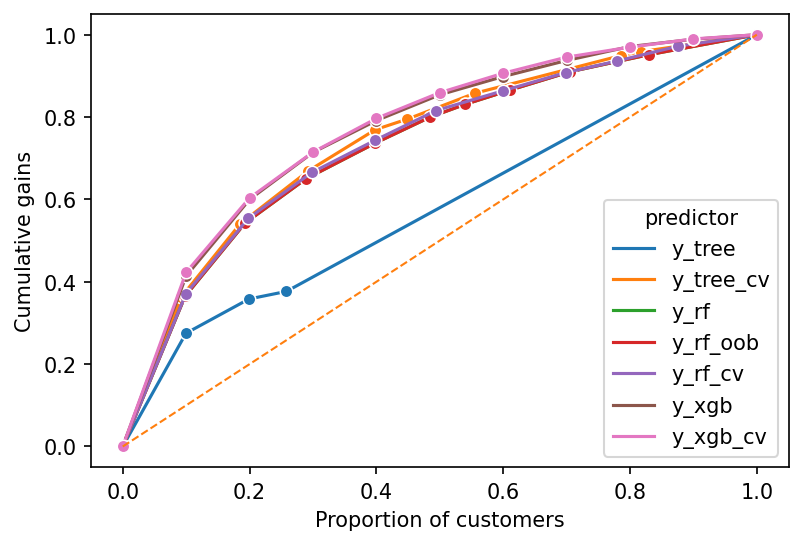

In [67]:
fig = rsm.gains_plot(eval_dat.query("training == 0"), "buyer_yes", 1, models[4:])

Summarize performance across all models in both training and test

In [68]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
perf = rsm.evalbin(dct, "buyer_yes", 1, models, cost=0.5, margin=6)
perf

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_lr,2356,8624,23211,809,35000,0.744,0.729,0.215,0.333,0.730,0.224,8646.0,0.545,1.575,0.314,0.814
1,training,y_lasso,2342,8501,23334,823,35000,0.740,0.733,0.216,0.334,0.734,0.226,8630.5,0.544,1.592,0.310,0.814
2,training,y_nn,2327,8373,23462,838,35000,0.735,0.737,0.217,0.336,0.737,0.228,8612.0,0.543,1.610,0.306,0.814
3,training,y_nn_cv,2350,8245,23590,815,35000,0.742,0.741,0.222,0.342,0.741,0.235,8802.5,0.555,1.662,0.303,0.822
4,training,y_tree,3006,1528,30307,159,35000,0.950,0.952,0.663,0.781,0.952,0.755,15769.0,0.995,6.956,0.130,0.994
5,training,y_tree_cv,2214,7419,24416,951,35000,0.700,0.767,0.230,0.346,0.761,0.243,8467.5,0.534,1.758,0.275,0.804
6,training,y_rf,3165,3111,28724,0,35000,1.000,0.902,0.504,0.670,0.911,0.625,15852.0,1.000,5.052,0.179,1.000
7,training,y_rf_oob,2178,9696,22139,987,35000,0.688,0.695,0.183,0.290,0.695,0.171,7131.0,0.450,1.201,0.339,0.749
8,training,y_rf_cv,2221,9599,22236,944,35000,0.702,0.698,0.188,0.296,0.699,0.179,7416.0,0.468,1.255,0.338,0.763
9,training,y_xgb,2506,8052,23783,659,35000,0.792,0.747,0.237,0.365,0.751,0.263,9757.0,0.616,1.848,0.302,0.853


In [69]:
# sort on any metric you like to get the "best" model
perf[perf.Type == "test"].sort_values(by="profit", ascending=False).reset_index(
    drop=True
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,test,y_nn_cv,993,3595,10048,364,15000,0.732,0.736,0.216,0.334,0.736,0.226,3664.0,1.000,1.597,0.306,0.813
1,test,y_xgb,975,3576,10067,382,15000,0.718,0.738,0.214,0.330,0.736,0.222,3574.5,0.976,1.571,0.303,0.799
2,test,y_nn,979,3631,10012,378,15000,0.721,0.734,0.212,0.328,0.733,0.219,3569.0,0.974,1.548,0.307,0.806
3,test,y_xgb_cv,993,3786,9857,364,15000,0.732,0.722,0.208,0.324,0.723,0.213,3568.5,0.974,1.493,0.319,0.805
4,test,y_lasso,980,3678,9965,377,15000,0.722,0.730,0.210,0.326,0.730,0.216,3551.0,0.969,1.525,0.311,0.806
5,test,y_lr,984,3741,9902,373,15000,0.725,0.726,0.208,0.324,0.726,0.213,3541.5,0.967,1.499,0.315,0.806
6,test,y_tree_cv,881,3222,10421,476,15000,0.649,0.764,0.215,0.323,0.753,0.216,3234.5,0.883,1.577,0.274,0.773
7,test,y_rf_cv,951,4138,9505,406,15000,0.701,0.697,0.187,0.295,0.697,0.178,3161.5,0.863,1.242,0.339,0.766
8,test,y_rf,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.862,1.256,0.335,0.760
9,test,y_rf_oob,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.862,1.256,0.335,0.760


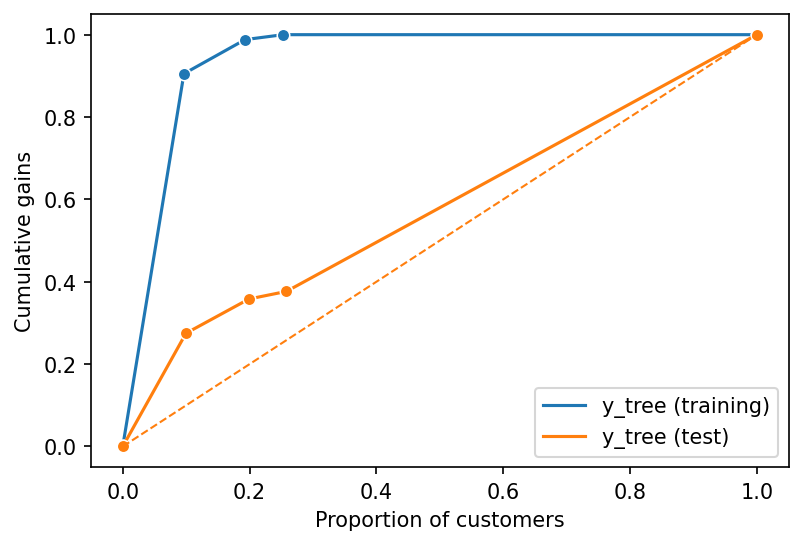

In [70]:
# compare gains from decision tree in training vs test
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
fig = rsm.gains_plot(dct, "buyer_yes", 1, "y_tree")

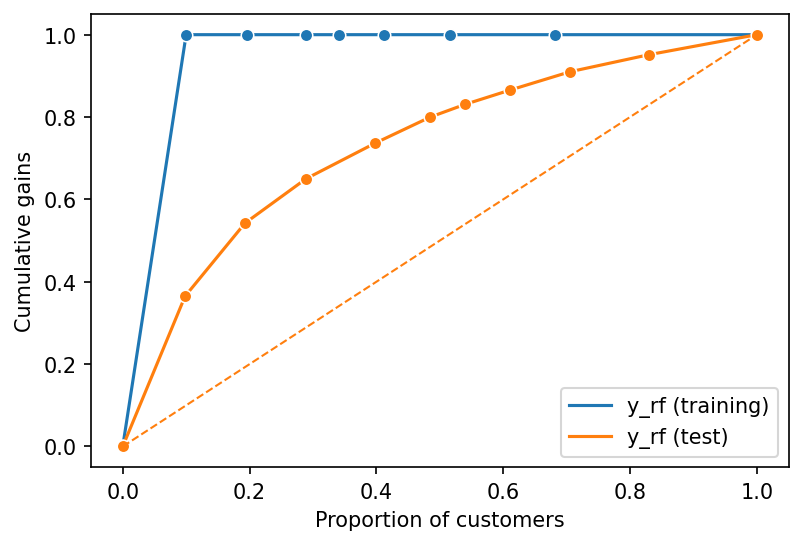

In [71]:
# compare gains for RandomForest in training vs test without OOB
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
fig = rsm.gains_plot(dct, "buyer_yes", 1, "y_rf")

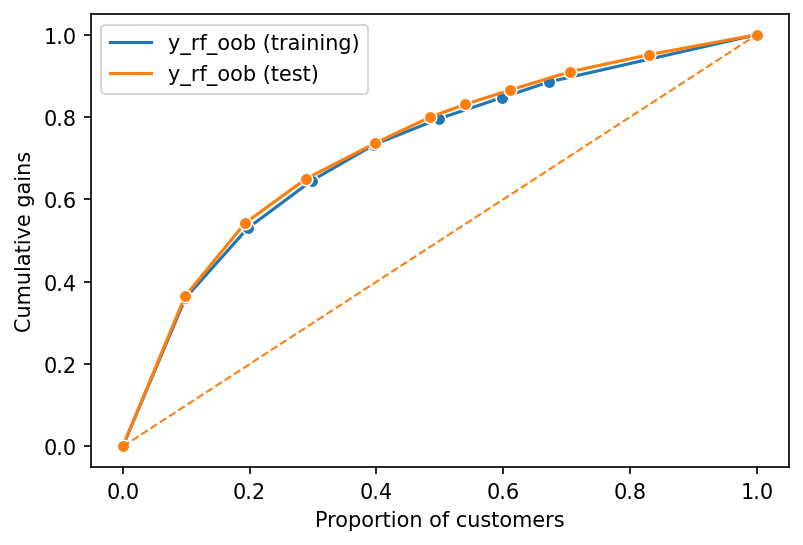

In [72]:
# compare gains for RandomForest (OOB) in training vs test with OOB
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
fig = rsm.gains_plot(dct, "buyer_yes", 1, "y_rf_oob")

When using any machine learning model you should *always* create plots of the (1) relative importance of variables the (2) the direction of the effect. Use permutation importance for the importance plot and use partial dependence plots to get a sense of the direction of the effect (positive, negative, non-linear)

In [73]:
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    # early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234,
).fit(X[training == 1], y[training == 1], verbose=True)

/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance, plot_partial_dependence


def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

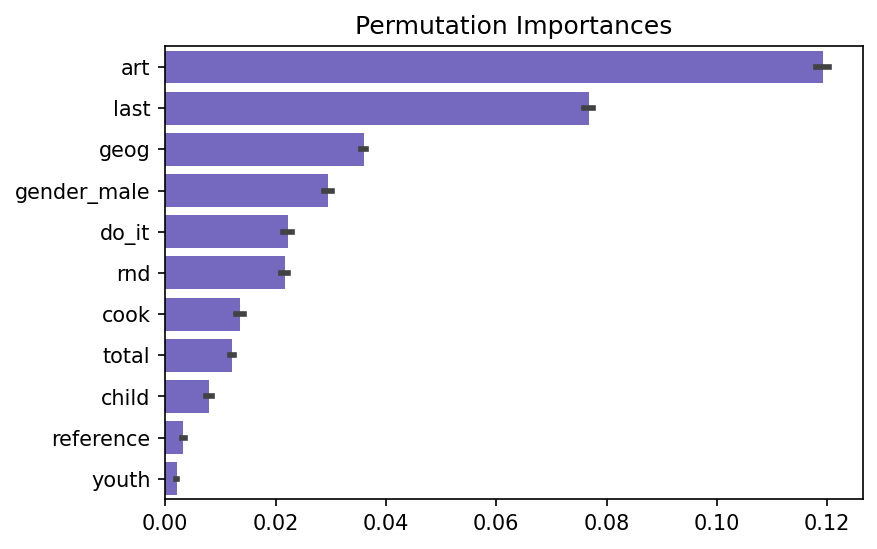

In [75]:
fig = importance(clf, X, y, X.columns)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


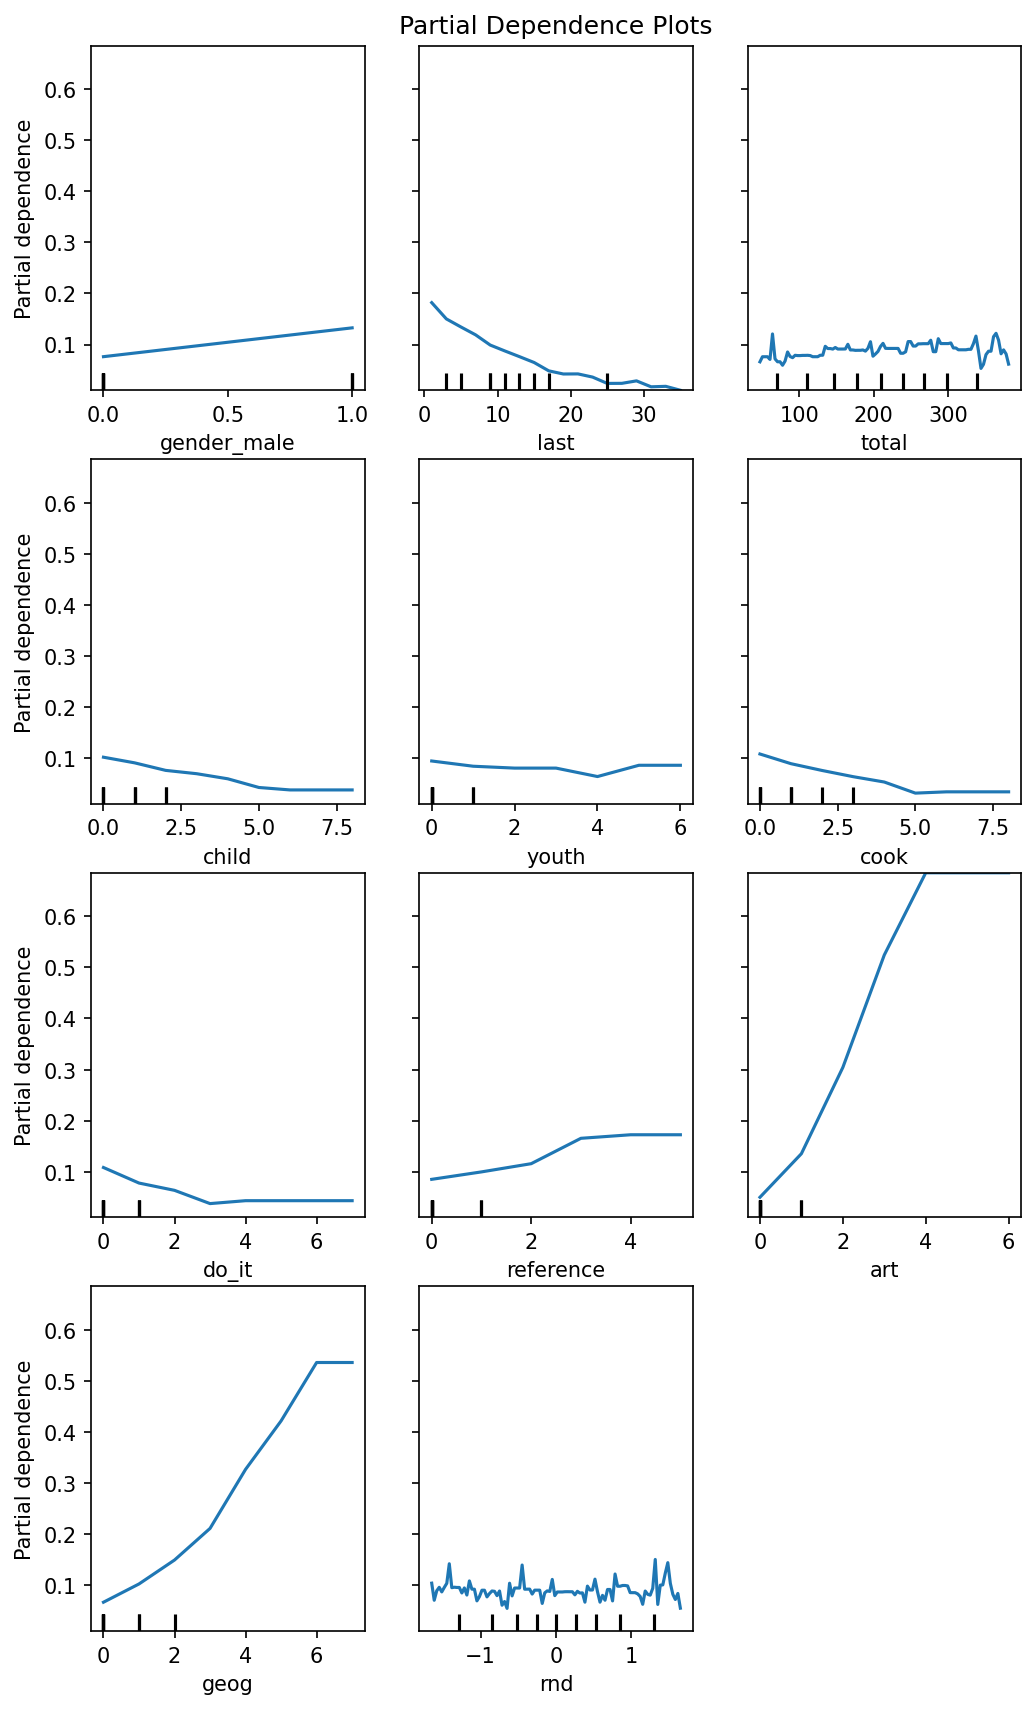

In [76]:
fig, ax = plt.subplots(figsize=(8, 14))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(clf, X, X.columns, ax=ax)

The first plot below can be used to indicate possible interaction effects

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


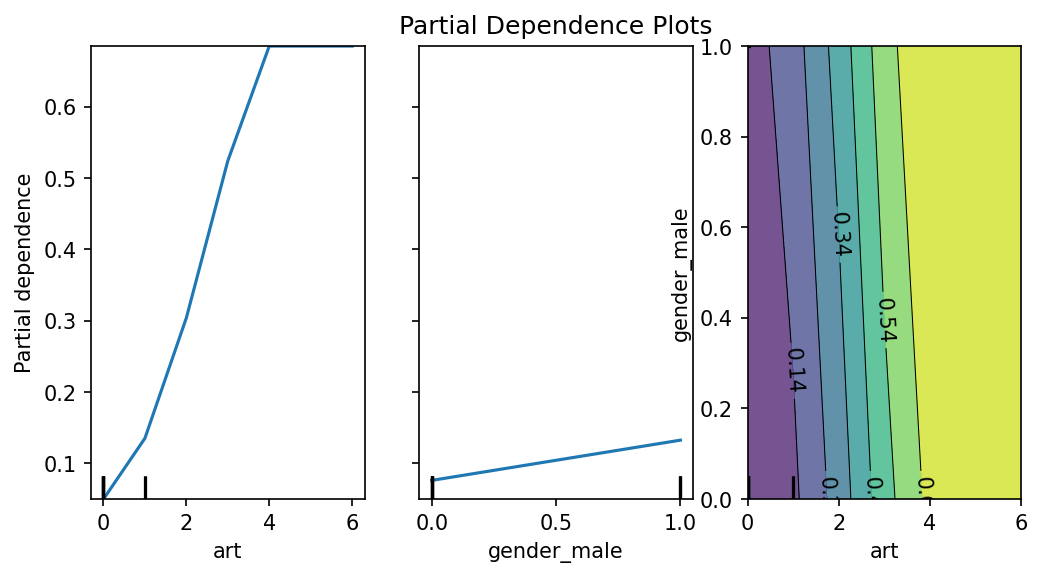

In [77]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(
    clf, X, ["art", "gender_male", ("art", "gender_male")], ax=ax
)